---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>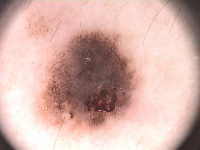</td><td>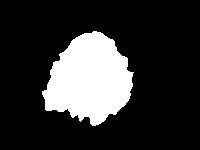</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!gdown https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7 -O PH2Dataset.rar

Downloading...
From: https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7
To: /content/PH2Dataset.rar
100% 116M/116M [00:00<00:00, 304MB/s] 


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

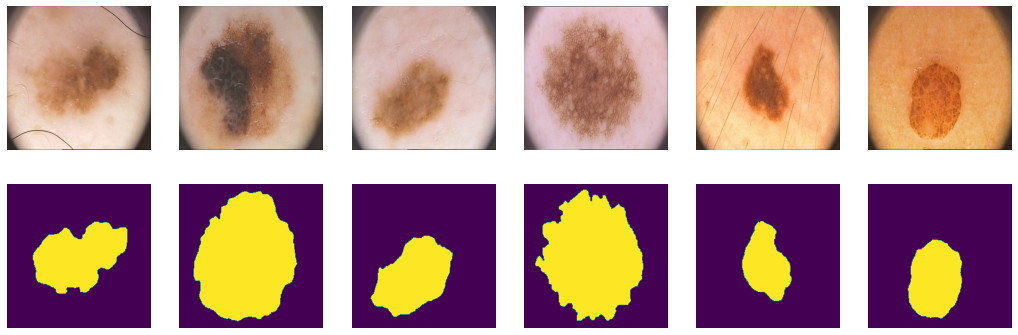

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
from torch.nn.modules.pooling import MaxUnpool2d
from torch.nn.modules.batchnorm import BatchNorm2d
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            
            nn.Conv2d(3,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 =  nn.MaxPool2d(kernel_size=2,return_indices=True)

        self.enc_conv1 = nn.Sequential(

            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.enc_conv2 = nn.Sequential(

            nn.Conv2d(128,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.enc_conv3 = nn.Sequential(

            nn.Conv2d(256,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.enc_conv4 = nn.Sequential(

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2,return_indices=True)
        
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv0 = nn.Sequential(

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv1 = nn.Sequential(

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv2 = nn.Sequential(

            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )   
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv3 = nn.Sequential(

            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 
        self.upsample4 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv4 = nn.Sequential(

            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,1,3,padding=1),
            nn.BatchNorm2d(1),
        )
    def forward(self, x):
        # encoder
        x = self.enc_conv0(x)
        x, ind0 = self.pool0(x)
        size0 = x.size()
        
        x = self.enc_conv1(x)
        x, ind1 = self.pool1(x)
        size1 = x.size()
        
        x = self.enc_conv2(x)
        x, ind2 = self.pool2(x)
        size2 = x.size()
        
        x = self.enc_conv3(x)
        x, ind3 = self.pool3(x)
        size3 = x.size()
        
        x = self.enc_conv4(x)
        x, ind4 = self.pool4(x)
       
        # decoder
        x =  self.upsample0(x,ind4,output_size=size3)
        x = self.dec_conv0(x)

        x =  self.upsample1(x,ind3,output_size=size2)
        x = self.dec_conv1(x)

        x =  self.upsample2(x,ind2,output_size=size1)
        x = self.dec_conv2(x)

        x =  self.upsample3(x,ind1,output_size=size0)
        x = self.dec_conv3(x)

        x =  self.upsample4(x,ind0)
        x = self.dec_conv4(x)
        return x

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou #

## Функция потерь [1 балл]


In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
   
    y_real,y_pred = y_real.cpu(),y_pred.cpu()
    y_pred= (torch.sigmoid(y_pred)).float()
    loss= y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred))
    
    
    return torch.mean(loss)#loss(y_pred,y_real)

## Тренировка [1 балл]



In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    losses = {
        'train':[],
        'val':[]
    }
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward

            Y_pred= model(X_batch)
        
            loss =  loss_fn(Y_batch,Y_pred)# forward-pass
            losses['train'].append((loss.detach().cpu().numpy()).mean())
            #loss.requires_grad=True
            loss.backward()  # backward-pass
            opt.step()  # update weights
            
            
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()
        for X_val,Y_val in data_val:
            X_val , Y_val = X_val.to(device), Y_val.to(device)
            Y_pred_val = model(X_val)
            losses['val'].append((loss_fn(Y_val,Y_pred_val).detach().cpu().numpy()).mean())
            
        Y_hat = Y_pred_val.detach().cpu()#Y_pred.cpu().detach().numpy()# detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow((Y_hat[k, 0].cpu() > 0.5), cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return losses

## Инференс [1 балл]



In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric((torch.sigmoid(Y_pred)>0.5), Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение




In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
model = SegNet().to(device)

In [ ]:
#!pip install torch-summary
from torchsummary import summary
#summary(model,(3,256,256))

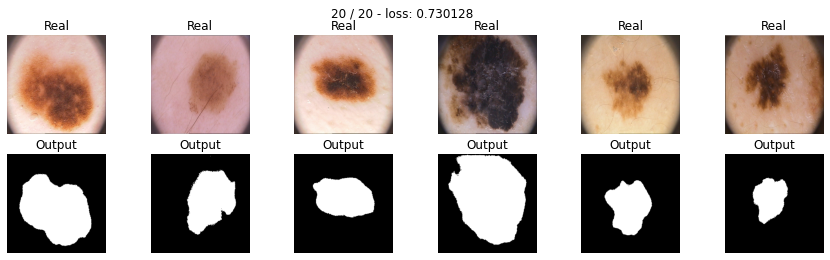

In [ ]:
max_epochs = 20

optim= torch.optim.Adam(model.parameters(),lr=1e-4)
segnet_bce = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
segnet_bce_val = score_model(model, iou_pytorch, data_val)

segnet_bce_val

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.8272275328636169

*Если запускать ячейку с train один раз, то модель не переобучается. Об этом свидетельствует не суперское определение маски, но на следующих запусках некоторые фотографии уже сначала имели практически правильные маски. Если продолжать запускать модель на тех же картинках,то переобучение неизбежно.*

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

**1. Dice coefficient:** 


In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = y_pred.view(-1)  
    y_real = y_real.view(-1)
    intersection = (y_pred * y_real).sum()
    smooth= 0 #0 #1e-10
    return 1 - (1/(256*256)) * ((2. * intersection + smooth) / (y_real.sum() + y_pred.sum() + smooth))

Проводим тестирование:

In [ ]:
torch.cuda.memory.empty_cache()

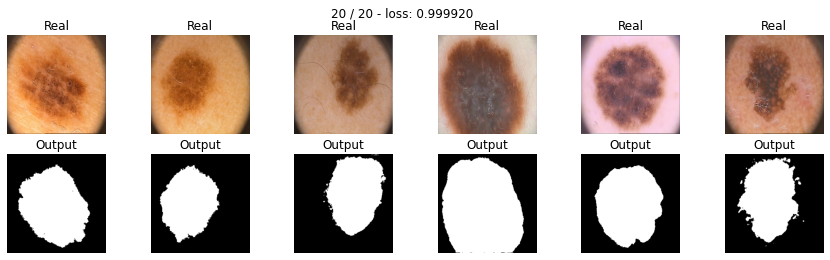

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model_dice.parameters(),lr=1e-3)
segnet_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
segnet_dice_val = score_model(model_dice, iou_pytorch, data_val)

segnet_dice_val

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.7915791153907776

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 




In [ ]:
def focal_loss(y_real, y_pred, gamma = 2):    
    ce = bce_loss(y_real,y_pred)
    pt = torch.exp(-ce)
    fl = torch.pow((1 - pt), gamma) * ce    
    return fl

In [ ]:
torch.cuda.memory.empty_cache()

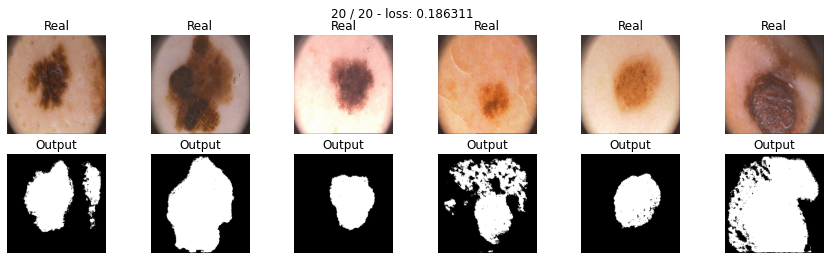

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 20
optimaizer = torch.optim.Adam(model_focal.parameters())
segnet_fl = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
segnet_fl_val = score_model(model_focal, iou_pytorch, data_val)

segnet_fl_val

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.7140708923339844

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

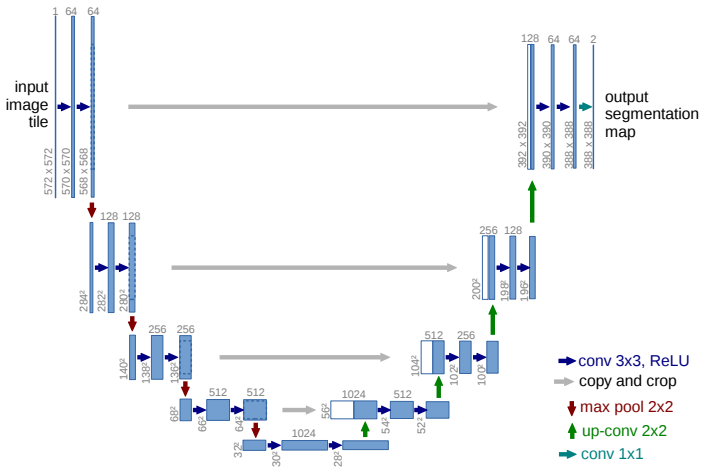

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    
    def conv_base(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
    
    def enc_l(self, in_channels, out_channels):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.conv_base(in_channels, out_channels)
        )
    
    def __init__(self):
        super().__init__()
        
        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64,3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64,3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.enc_conv1 = self.enc_l(64, 128)
        self.enc_conv2 = self.enc_l(128, 256)
        self.enc_conv3 = self.enc_l(256, 512)
        self.enc_conv4 = self.enc_l(512, 512)
        # decoder 
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = self.conv_base(2 * 512, 256)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = self.conv_base(2 * 256, 128)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = self.conv_base(2 * 128, 64)
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
            self.conv_base(2 * 64, 64),
            nn.Conv2d(64, 1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)
        e4 = self.enc_conv4(e3)
        # bottleneck
        b = self.upsample0(e4)

        # decoder
        d0 = self.upsample1(self.dec_conv0(torch.cat((b, e3), dim=1)))
        d1 = self.upsample2(self.dec_conv1(torch.cat((d0, e2), dim=1)))
        d2 = self.upsample3(self.dec_conv2(torch.cat((d1, e1), dim=1)))
        d3 = self.dec_conv3(torch.cat((d2, e0), dim=1))  # no activation
        return d3

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
unet_model_bce = UNet().to(device)

In [ ]:
#summary(unet_model_bce,(3,256,256))

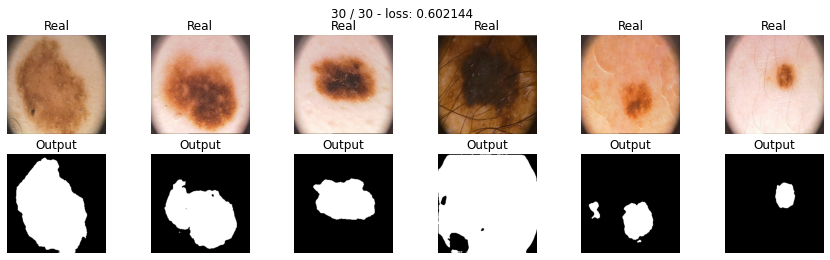

In [ ]:
unet_bce = train(unet_model_bce, torch.optim.Adam(unet_model_bce.parameters()), bce_loss, 60, data_tr, data_val)

In [ ]:
unet_bce_val = score_model(unet_model_bce, iou_pytorch, data_val)

unet_bce_val

0.8343066453933716

Теперь проверим модель UNet c функцией потерь FocalLoss. 

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
unet_model_fl = UNet().to(device)

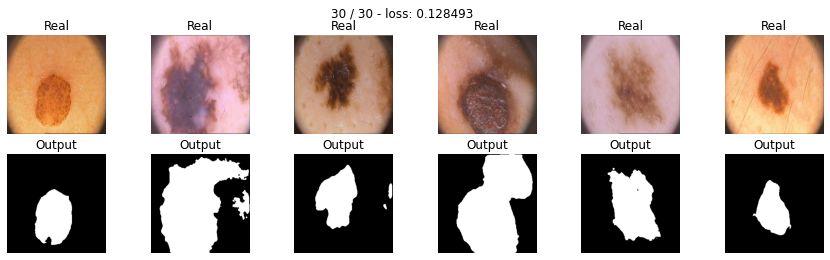

In [ ]:
unet_fl = train(unet_model_fl, torch.optim.Adam(unet_model_fl.parameters()), focal_loss, 60, data_tr, data_val)

In [ ]:
unet_fl_val = score_model(unet_model_fl, iou_pytorch, data_val)

unet_fl_val

0.8269806623458862

# Отчет

Были написаны 2 архитектуры сетей - SegNet, Unet. Также были написаны 3 различных функций лосса - BCEloss, Dice loss, Focal loss. Было нелегко, но интересно разобраться в каждом из пунктов задания, впоследствии это дало хорошее понимание работы моделей и семантической сегментации в общем.Были некоторые вопросы к ноутбуку задания, но совместными усилиями с одногруппниками они были решены. 

Ожидалось получить визуально приемлемые результаты работы -это основная цель задания для меня, но результаты метрики подкрепляют эти наблюдения. В большинстве моделей сегментированные области практически неотличимы от оригинальной фотографии, что не может не радовать, а учитывая, что это мой первый опыт в работе с подобными нейросетями и заданиями в общем, то результатом остался довольный.

Приступим к анализу. Сначала стоит проверить график лоссов на train выборке на каждой из функций. Хоть они и имеют разные по интервалам значения, но по каждому из них в отдельности можно сказать, обучается ли модель.

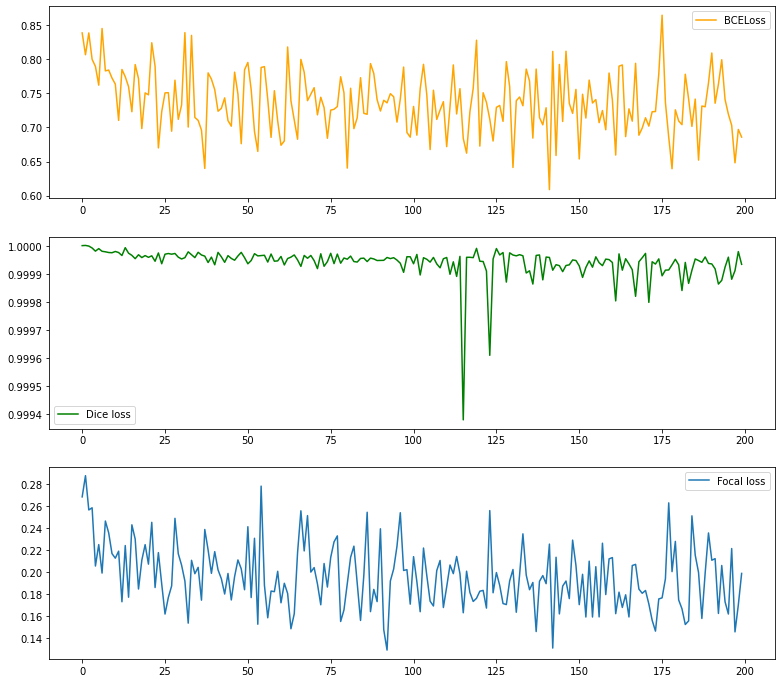

In [ ]:
rcParams['figure.figsize'] = (13,12)
plt.subplot(311)
plt.plot(segnet_bce['train'],label='BCELoss',color='orange')
plt.legend()
plt.subplot(312)
plt.plot(segnet_dice['train'],label = 'Dice loss',color='green')
plt.legend()
plt.subplot(313)
plt.plot(segnet_fl['train'], label = 'Focal loss')
plt.legend()

plt.show()

Как мы видим из графика выше, лосс имеет тенденцию к снижению у всех функций, что сигнализирует о том, что модель училась на этих 3 различных функциях лосса, однако Dice loss ведет себя не очень стабильно, можно подумать о дополнительной численной стабильности помимо smooth.

Теперь посмотрим лосс на val выборке.

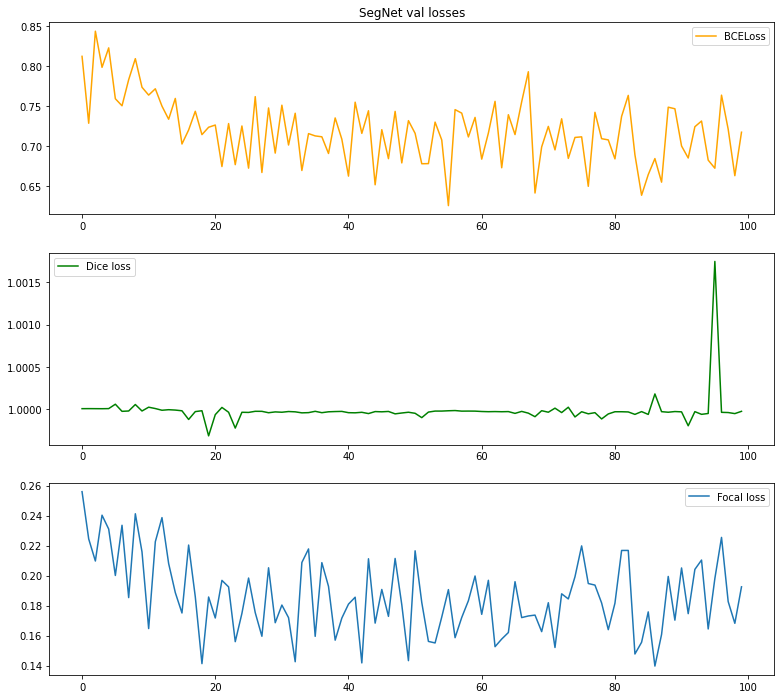

In [ ]:
rcParams['figure.figsize'] = (13,12)

plt.subplot(311)
plt.plot(segnet_bce['val'],label='BCELoss',color='orange')
plt.title('SegNet val losses')
plt.legend()
plt.subplot(312)
plt.plot(segnet_dice['val'],label = 'Dice loss',color='green')
plt.legend()
plt.subplot(313)
plt.plot(segnet_fl['val'], label = 'Focal loss')
plt.legend()

plt.show()

Здесь лосс тоже имеет тенденцию к снижению, значит модель не переобучилась и при наличии времени можно учить модель большее количество эпох. Diсe loss оставляет желать лучшего.

Взглянем score нашего SegNet обученной на разных функциях лосса.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


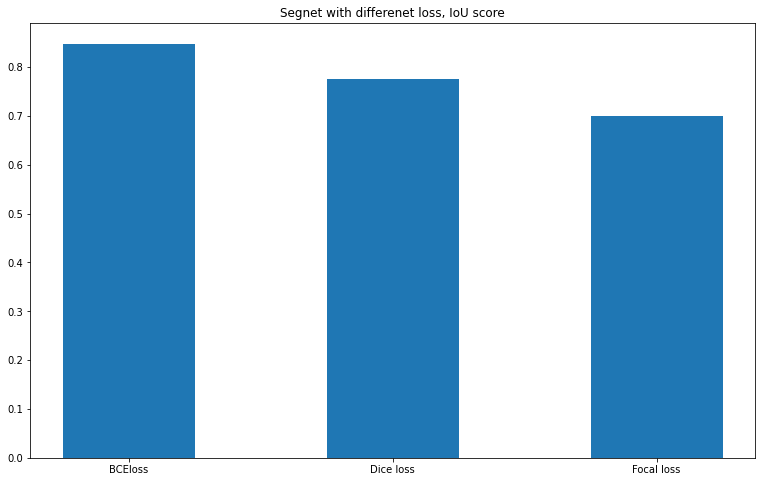

In [ ]:
score_segnet= [score_model(model, iou_pytorch, data_ts) ,
         score_model(model_dice, iou_pytorch, data_ts),
         score_model(model_focal, iou_pytorch, data_ts)
]
name_models = ['BCEloss','Dice loss','Focal loss']

rcParams['figure.figsize'] = (13,8)
plt.bar(name_models,score_segnet,width=0.5)
plt.title('Segnet with differenet loss, IoU score')
None

Нетрудно понять, что лучшие показатели метрики у SegNet были достигнуты на BCEloss, учтем это для сравнения в дальнейшем.

Повторим анализ и для UNet.

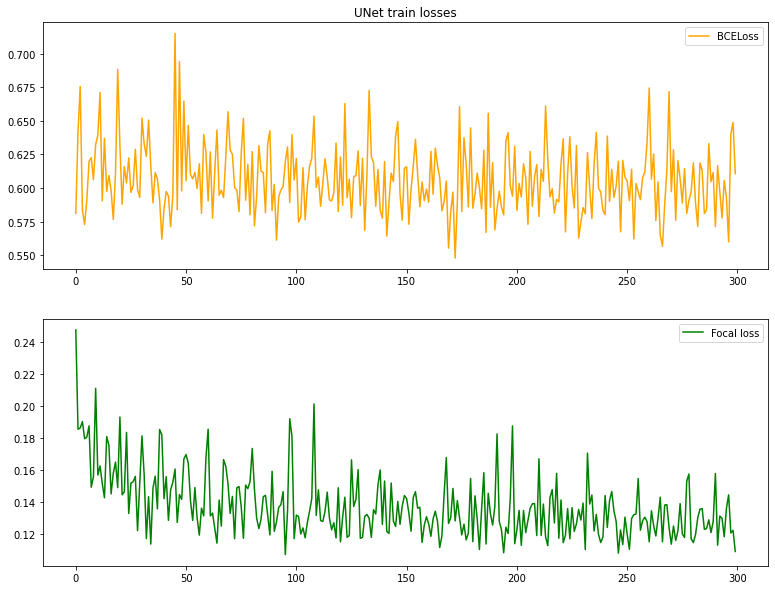

In [ ]:
rcParams['figure.figsize'] = (13,10)
plt.subplot(211)
plt.title('UNet train losses')
plt.plot(unet_bce['train'],label='BCELoss',color='orange')
plt.legend()
plt.subplot(212)
plt.plot(unet_fl['train'],label = 'Focal loss',color='green')
plt.legend()
plt.show()

На train все хорошо, лосс снижается.

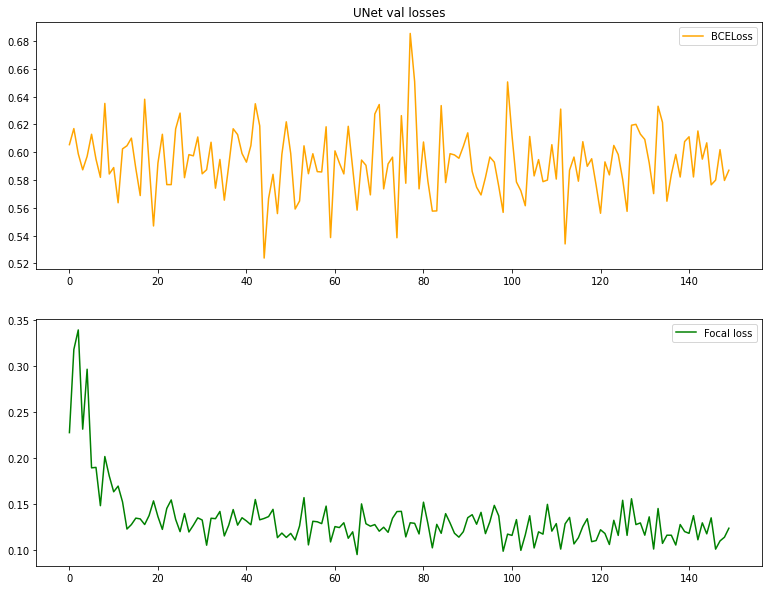

In [ ]:
plt.subplot(211)
plt.title('UNet val losses')
plt.plot(unet_bce['val'],label='BCELoss',color='orange')
plt.legend()
plt.subplot(212)
plt.plot(unet_fl['val'],label = 'Focal loss',color='green')
plt.legend()
plt.show()

Здесь с лоссом все хорошо, модель обучается и на 60 эпохах

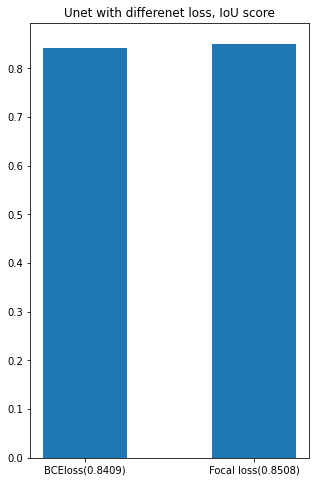

In [ ]:
score_segnet= [score_model(unet_model_bce, iou_pytorch, data_ts) ,
               score_model(unet_model_fl, iou_pytorch, data_ts),  
]
name_models = [f'BCEloss({score_model(unet_model_bce, iou_pytorch, data_ts):.4f})',f'Focal loss({score_model(unet_model_fl, iou_pytorch, data_ts):.4f})']
rcParams['figure.figsize'] = (5,8)
plt.bar(name_models,score_segnet,width=0.5)
plt.title('Unet with differenet loss, IoU score')
None

Focal loss, хоть и с небольщим отрывом, но превосходит BCE. Теперь сравним Focal loss UNet и BCE SegNet.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


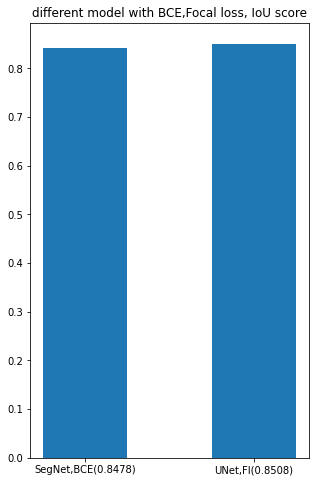

In [ ]:
score= [score_model(model, iou_pytorch, data_ts) ,
                    score_model(unet_model_bce, iou_pytorch, data_ts),  
]
name_models = [f'SegNet,BCE({score_model(model, iou_pytorch, data_ts):.4f})',f'UNet,Fl({score_model(unet_model_fl, iou_pytorch, data_ts):.4f})']
rcParams['figure.figsize'] = (5,8)
plt.bar(name_models,score_segnet,width=0.5)
plt.title('different model with BCE,Focal loss, IoU score')
None

По итогу лучшие показатели показала UNet с Focal Loss и 60 эпохами.

Вывод по обучению и метрикам: Показатели метрики далеко не идеальные, есть много возможностей по улучшению показателей. Самое очевидное - аугментации с семплированием, опробовать различный lr, доучить модели на большем количестве эпох. Также стоит подумать над лучшей стабильностью Dice loss, т.к. предложенное преподавателями приближение формулы и добавление eps(smooth) не дали полной стабильности.

Общий вывод: Точность 85% на тестовой выборке неплохой результат для начала. Примерно этого результата и ожидалось достичь. SegNet и UNet хорошо показали себя на такой задаче, как сегментация, в этом я собственноручно убедился. В моем сетапе лучшей оказалась UNet с Focal loss. 